In [ ]:
!pip install faiss-cpu -q
!pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import time
import random

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# HAC
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

# HDBSCAN
import hdbscan
from hdbscan.validity import validity_index

# FeatureEncode
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder
from category_encoders import CatBoostEncoder

# Feature weights
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# Cluster Explanation
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

import faiss

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
def preprocess_table(df):
    df = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Заполняем пропуски медианой, либо __MISSING__
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    for col in cat_cols:
        df[col] = df[col].fillna("__MISSING__").astype(str)

    return df, num_cols, cat_cols

In [ ]:
def compute_numeric_ranges(df, num_cols, method='minmax', iqr_multiplier=1.5):
    """
    Возвращает словарь {col: range} для нормализации
      - 'minmax'  : range = max - min
      - 'iqr' : range = (Q3-Q1) * iqr_multiplier
    """
    ranges = {}
    for c in num_cols:
        col = df[c].dropna().to_numpy(dtype=float)
        if col.size == 0:
            ranges[c] = 1.0
            continue

        if method == 'minmax':
            r = float(np.max(col) - np.min(col))
        elif method == 'iqr':
            q1 = np.percentile(col, 25)
            q3 = np.percentile(col, 75)
            r = float((q3 - q1) * iqr_multiplier)
        else:
            raise ValueError("unknown method")

        # Если range слишком мал, то ставим его 1.0
        if not np.isfinite(r) or r <= 1e-8:
            r = 1.0
        ranges[c] = r
    return ranges

In [ ]:
def compute_feature_weights(df, target, num_cols, cat_cols, task="regression"):
    """
    Считает веса признаков по взаимной информации (MI) с таргетом
    df : Входные данные
    target : pd.Series или np.array таргет (числовой или категориальный)
    task : str
        "regression" или "classification".

    output:
    weights : dict
        {column_name: weight}, веса нормированы (сумма = число признаков).
    """
    df = df.copy()
    y = target.values if isinstance(target, pd.Series) else np.array(target)

    # Кодируем категориальные
    df_enc = df.copy()
    discrete_features = []
    for c in cat_cols:
        le = LabelEncoder()
        df_enc[c] = le.fit_transform(df_enc[c].astype(str))
        discrete_features.append(df.columns.get_loc(c))  # индексы категориальных

    X = df_enc.to_numpy()

    # Вычисляем MI
    if task == "regression":
        mi = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=42)
    elif task == "classification":
        mi = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=42)
    else:
        raise ValueError("task должен быть 'regression' или 'classification'")

    # Нормируем веса (сумма = число признаков)
    mi = np.maximum(mi, 1e-9)  # чтобы не было нулевых
    mi_normalized = mi / mi.sum() * len(mi)

    weights = {col: w for col, w in zip(df.columns, mi_normalized)}
    return weights


In [ ]:
def compute_gower_matrix(df, num_cols, cat_cols, numeric_ranges=None,
                          weights=None, dtype=np.float32):
    """
    - numeric_ranges: dict col->range. Если None, computed by minmax on df.
    - weights: dict col->weight. Если None - все 1
    """
    X = df.reset_index(drop=True)
    n = len(X)
    if n == 0:
        return np.zeros((0,0), dtype=dtype)

    if numeric_ranges is None:
        numeric_ranges = compute_numeric_ranges(X, num_cols, method='minmax')

    D = np.zeros((n, n), dtype=np.float64)  # accumulate in float64 for numeric stability

    # weights
    if weights is None:
        # equal weight per feature
        w_num = {c: 1.0 for c in num_cols}
        w_cat = {c: 1.0 for c in cat_cols}
    else:
        # user-provided; missing keys default to 1.0
        w_num = {c: float(weights.get(c, 1.0)) for c in num_cols}
        w_cat = {c: float(weights.get(c, 1.0)) for c in cat_cols}

    # numeric part
    for c in num_cols:
        col = X[c].to_numpy(dtype=float)
        rng = numeric_ranges.get(c, 1.0)
        # normalized differences (broadcast)
        mat = np.abs(col[:, None] - col[None, :]) / rng
        D += w_num.get(c, 1.0) * mat

    # categorical part
    for c in cat_cols:
        col = X[c].astype(str).to_numpy()
        neq = (col[:, None] != col[None, :]).astype(np.float64)
        D += w_cat.get(c, 1.0) * neq

    # normalize by total weights sum
    total_weight = sum(w_num.values()) + sum(w_cat.values())
    if total_weight <= 0:
        total_weight = 1.0
    D = (D / float(total_weight)).astype(dtype)
    return D

In [ ]:
def tune_hdbscan(D, param_grid, d):
    best_score = -1
    best_params = None
    best_labels = None

    for params in param_grid:
        cl = hdbscan.HDBSCAN(metric="precomputed", **params)
        labels = cl.fit_predict(D)

        if len(set(labels)) > 1:
            score = validity_index(
                D,
                labels,
                metric="precomputed",
                d=d
            )
            if score > best_score:
                best_score = score
                best_params = params
                best_labels = labels
    return best_params, best_score, best_labels

def cluster_subsample(df_S, num_cols, cat_cols, target=None, method="hac", max_k=20):
    """
    Кластеризация на подвыборке.
    method = "hdbscan" или "hac"
    """

    weights = None
    if target is not None:
      weights = compute_feature_weights(df_S, target, num_cols, cat_cols)
      #print(weights)

    # считаем Gower distance
    D = compute_gower_matrix(df_S, num_cols, cat_cols, weights=weights)

    if method == "hdbscan":
        cl = hdbscan.HDBSCAN(
            metric="precomputed"
        )
        # specify parameters and distributions to sample from
        param_grid = [
            {"min_cluster_size": mcs, "min_samples": ms, "cluster_selection_method": csm}
            for mcs in [10, 20, 30, 50, 100]
            for ms in [5, 10, 20, 30, 50, 100]
            for csm in ["eom", "leaf"]
        ]
        d = len(num_cols) + len(cat_cols)
        best_params, best_score, labels = tune_hdbscan(
            D.astype(np.float64), param_grid, d)

        print("Best params:", best_params)
        print("Best validity:", best_score)

    elif method == "hac":
        # преобразуем матрицу в condensed form
        condensed = squareform(D, checks=False)

        # linkage (average linkage лучше для Gower)
        Z = linkage(condensed, method="complete")

        # поиск оптимального k по silhouette
        best_k, best_score, best_labels = None, -1, None
        for k in range(2, min(max_k, len(df_S)//100)):
            labels = fcluster(Z, k, criterion="maxclust")
            if len(np.unique(labels)) < 2:
                continue
            try:
                score = silhouette_score(D, labels, metric="precomputed")
            except Exception:
                continue
            if score > best_score:
                best_score, best_k, best_labels = score, k, labels

        if best_labels is None:
            # fallback: всё в один кластер
            best_labels = np.ones(len(df_S), dtype=int)

        labels = best_labels

    else:
        raise ValueError("method must be 'hdbscan' or 'hac'")

    return labels

In [ ]:
def vectorize(df, num_cols, cat_cols, ohe_thresh=20, hash_dim=32):
    """
    Преобразует таблицу в числовой массив для кластеризации / поиска соседей.

    Parameters:
        df : pd.DataFrame
        numeric_cols : list[str] - числовые колонки
        cat_cols : list[str] - категориальные колонки
        ohe_thresh : int - макс число уникальных категорий для OHE
        hash_dim : int - размер выходного вектора для FeatureHasher

    output:
        X : np.ndarray, float32
    """
    # --- числовые ---
    scaler = RobustScaler()
    X_num = scaler.fit_transform(df[num_cols]) if num_cols else None

    # --- категориальные ---
    X_cat_list = []
    encoders = {}

    for c in cat_cols:
        n_unique = df[c].nunique()
        col_data = df[[c]].astype(str)

        if n_unique <= ohe_thresh:
            # OHE
            enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            X_c = enc.fit_transform(col_data)
            encoders[c] = enc
        else:
            # FeatureHasher
            enc = FeatureHasher(n_features=hash_dim, input_type='string')
            # FeatureHasher принимает список словарей: [{cat_val: 1}, ...]
            X_c = enc.transform([{val: 1} for val in col_data[c]]).toarray()
            encoders[c] = enc
        X_cat_list.append(X_c)

    if X_cat_list:
        X_cat = np.hstack(X_cat_list)
    else:
        X_cat = None

    # --- объединение ---
    if X_num is not None and X_cat is not None:
        X = np.hstack([X_num, X_cat])
    elif X_num is not None:
        X = X_num
    else:
        X = X_cat

    return X.astype(np.float32)

In [ ]:
def build_faiss_hnsw(X_S, M=32, efSearch=64):
    """
    Создаёт HNSW индекс FAISS для подвыборки X_S

    Parameters:
        X_S : np.ndarray, shape (n_S, dim), float32
        M : int, число соседей в графе HNSW
        efSearch : int, ширина поиска
    Returns:
        index : faiss.IndexHNSWFlat
    """
    dim = X_S.shape[1]
    index = faiss.IndexHNSWFlat(dim, M)
    index.hnsw.efSearch = efSearch
    index.add(X_S)
    return index

def assign_faiss(index, X_rest, labels_S, k=3, ood_threshold=None, weighted=True):
    """
    Приписывает новые точки к кластерам из labels_S через HNSW

        index : faiss.IndexHNSWFlat, построенный на кластеризованном сэмпле X_S
        X_rest : новые точки из некластеризованной выборки
        labels_S : метки кластеров
        k : число ближайших соседей
        ood_threshold : float или None, порог для OOD; если None - вычисляется как 99-й перцентиль расстояний в S
        weighted : bool, использовать взвешенное голосование по расстоянию

    Output:
        assigned_labels : присвоенные лейбл
        assign_distance : расстояние до выбранного кластера
        is_OOD : True если объект OOD
    """
    n_S = labels_S.shape[0]
    k = min(k, n_S)

    D, I = index.search(X_rest, k)  # distances & indices
    n_rest = X_rest.shape[0]
    assigned_labels = np.empty(n_rest, dtype=int)
    assign_distance = np.empty(n_rest, dtype=float)
    is_OOD = np.zeros(n_rest, dtype=bool)

    # OOD threshold если не задан
    if ood_threshold is None:
        # эмпирический 99-й перцентиль всех расстояний внутри S
        # D_self: расстояния до 1-го ближайшего соседа в S (exclude self)
        D_self, _ = index.search(index.reconstruct_n(0, n_S), 2)
        D_self = D_self[:, 1]  # первый сосед = сам объект, берем 2-й
        ood_threshold = np.quantile(D_self, 0.99)

    for i in range(n_rest):
        neigh_idxs = I[i]
        neigh_dists = D[i]
        neigh_labels = labels_S[neigh_idxs]

        if weighted:
            # взвешенное голосование: 1/(dist+1e-9)
            weights = 1.0 / (neigh_dists + 1e-9)
            label_score = {}
            for lbl, w in zip(neigh_labels, weights):
                label_score[lbl] = label_score.get(lbl, 0.0) + w
            # выбираем label с максимальной суммы весов
            assigned_label = max(label_score.items(), key=lambda x: x[1])[0]
        else:
            # через ArgMax
            vals, counts = np.unique(neigh_labels, return_counts=True)
            assigned_label = vals[np.argmax(counts)]

        assigned_labels[i] = assigned_label
        # расстояние до ближайшего соседа с выбранным label
        mask = neigh_labels == assigned_label
        assign_distance[i] = neigh_dists[mask].min()
        # OOD
        is_OOD[i] = assign_distance[i] > ood_threshold

    return assigned_labels, assign_distance, is_OOD

In [ ]:
def pipeline_faiss(df, target=None, sample_size=8000, k=3, M=32, efSearch=64, clust_method='hdbscan'):

    # --- предобработка ---
    df_prep, num_cols, cat_cols = preprocess_table(df)

    # --- векторизация всей выборки ---
    X = vectorize(df_prep, num_cols, cat_cols)

    N = len(df_prep)
    S = min(sample_size, N)
    idx_all = np.arange(N)
    idx_S = np.random.choice(idx_all, size=S, replace=False)
    idx_rest = np.setdiff1d(idx_all, idx_S)

    X_S = X[idx_S]
    X_rest = X[idx_rest]
    if target is not None:
      target=target.iloc[idx_S]

    # --- кластеризация на подвыборке ---
    labels_S = cluster_subsample(df_prep.iloc[idx_S], num_cols, cat_cols, target, method=clust_method)

    # --- FAISS HNSW index ---
    index = build_faiss_hnsw(X_S, M=M, efSearch=efSearch)

    # --- assign остальных ---
    labels_rest, dist_rest, is_ood = assign_faiss(index, X_rest, labels_S, k=k)

    # --- собрать результат ---
    result = df_prep.copy()
    result['cluster'] = np.nan
    result['assign_distance'] = np.nan
    result['is_OOD'] = False

    # метки для подвыборки
    result.loc[idx_S, 'cluster'] = labels_S
    result.loc[idx_S, 'assign_distance'] = 0.0
    result.loc[idx_S, 'is_OOD'] = False

    # метки для остальных
    result.loc[idx_rest, 'cluster'] = labels_rest
    result.loc[idx_rest, 'assign_distance'] = dist_rest
    result.loc[idx_rest, 'is_OOD'] = is_ood

    return result

In [ ]:
df = pd.read_csv('sever.csv')
df.head()

,Номер Z-конфигурации,КлчПост/Потребн,Количество (Норматив),TOL,SHIRINA,DLINA,VID_TO,MARKA,ST_PROD
0,401077983,53.526,1197.6,58.0,2440,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
1,401090004,55.476,1197.6,32.2,2260,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
2,401090006,47.301,1197.6,33.0,1880,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
3,401090005,46.477,1197.6,38.0,1609,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
4,401089979,143.408,1197.6,58.0,2450,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)


In [ ]:
res = pipeline_faiss(df.drop(['Номер Z-конфигурации', 'Количество (Норматив)'], axis=1), target=df['Количество (Норматив)'])

In [ ]:
res['cluster'].value_counts()
res['target'] = df['Количество (Норматив)']
df['cluster'] = res['cluster']

In [ ]:
def analyze_clusters(df, target_col="Количество (Норматив)", cluster_col="cluster", max_depth=6):
    results = {}
    num_cols = df.drop([cluster_col, target_col], axis=1).select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Распределение таргета по кластерам
    summary = df.groupby(cluster_col)[target_col].agg(
        ["count", "mean", "std", "min", "max", "median"]
    ).sort_values("mean", ascending=False)
    print(" Распределение таргета по кластерам:")
    print(summary)

    # Объяснение кластеров через DecisionTreeClassifier
    X = df[num_cols + cat_cols]
    y = df[cluster_col]

    preproc = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols),
            ("cat", CatBoostEncoder(handle_unknown="ignore"), cat_cols)
        ]
    )

    clf = Pipeline([
        ("prep", preproc),
        ("tree", DecisionTreeClassifier(max_depth=max_depth, random_state=42))
    ])

    clf.fit(X, y)

    plt.figure(figsize=(30, 25))
    plot_tree(clf.named_steps["tree"],
              feature_names=clf.named_steps["prep"].get_feature_names_out(),
              class_names=[str(c) for c in np.unique(y)],
              filled=True)
    plt.title(" Правила, объясняющие кластеры")
    plt.show()

    importances = pd.Series(
        clf.named_steps["tree"].feature_importances_,
        index=clf.named_steps["prep"].get_feature_names_out()
    ).sort_values(ascending=False)

    print("\n Главные признаки, формирующие кластеры:")
    print(importances.head(10))

    results["cluster_importances"] = importances

    # Анализ таргета внутри каждого кластера
    target_results = {}
    for clust in sorted(df[cluster_col].dropna().unique()):
        subset = df[df[cluster_col] == clust]
        if len(subset) < 20:
            continue  # маленькие кластеры игнорируем

        X_sub = subset[num_cols + cat_cols]
        y_sub = subset[target_col]

        reg = Pipeline([
            ("prep", preproc),
            ("tree", DecisionTreeRegressor(max_depth=4, random_state=42))
        ])

        reg.fit(X_sub, y_sub)

        importances = pd.Series(
            reg.named_steps["tree"].feature_importances_,
            index=reg.named_steps["prep"].get_feature_names_out()
        ).sort_values(ascending=False)

        target_results[clust] = importances

        print(f"\n Кластер {clust}: факторы, влияющие на таргет")
        print(importances.head(5))
        plt.figure(figsize=(20, 15))
        plot_tree(reg.named_steps["tree"],
                  feature_names=reg.named_steps["prep"].get_feature_names_out(),
                  class_names=[str(c) for c in np.unique(y)],
                  filled=True)
        plt.title(f" Правила, объясняющие кластер {clust}")
        plt.show()

    results["target_within_clusters"] = target_results

    return results

 Распределение таргета по кластерам:
         count         mean         std       min       max   median
cluster                                                             
5.0         25  1233.188000  103.242838  1144.100  1433.100  1188.00
4.0         10  1226.570000  114.750445  1160.000  1500.000  1176.45
8.0         34  1212.914118   42.148122  1186.700  1413.300  1199.30
10.0       269  1198.144981   36.282527  1144.300  1410.000  1194.00
2.0        350  1196.860686   65.240568  1056.212  2010.000  1197.60
6.0         63  1171.573016   16.692293  1130.000  1207.300  1162.70
9.0         44  1158.447727   23.864613  1129.300  1178.900  1178.90
1.0        144  1158.172090   13.074193  1144.100  1228.481  1163.60
7.0         42  1157.061905    6.384812  1149.000  1165.000  1152.00
3.0        181  1147.716575   25.080166  1118.900  1281.200  1160.00


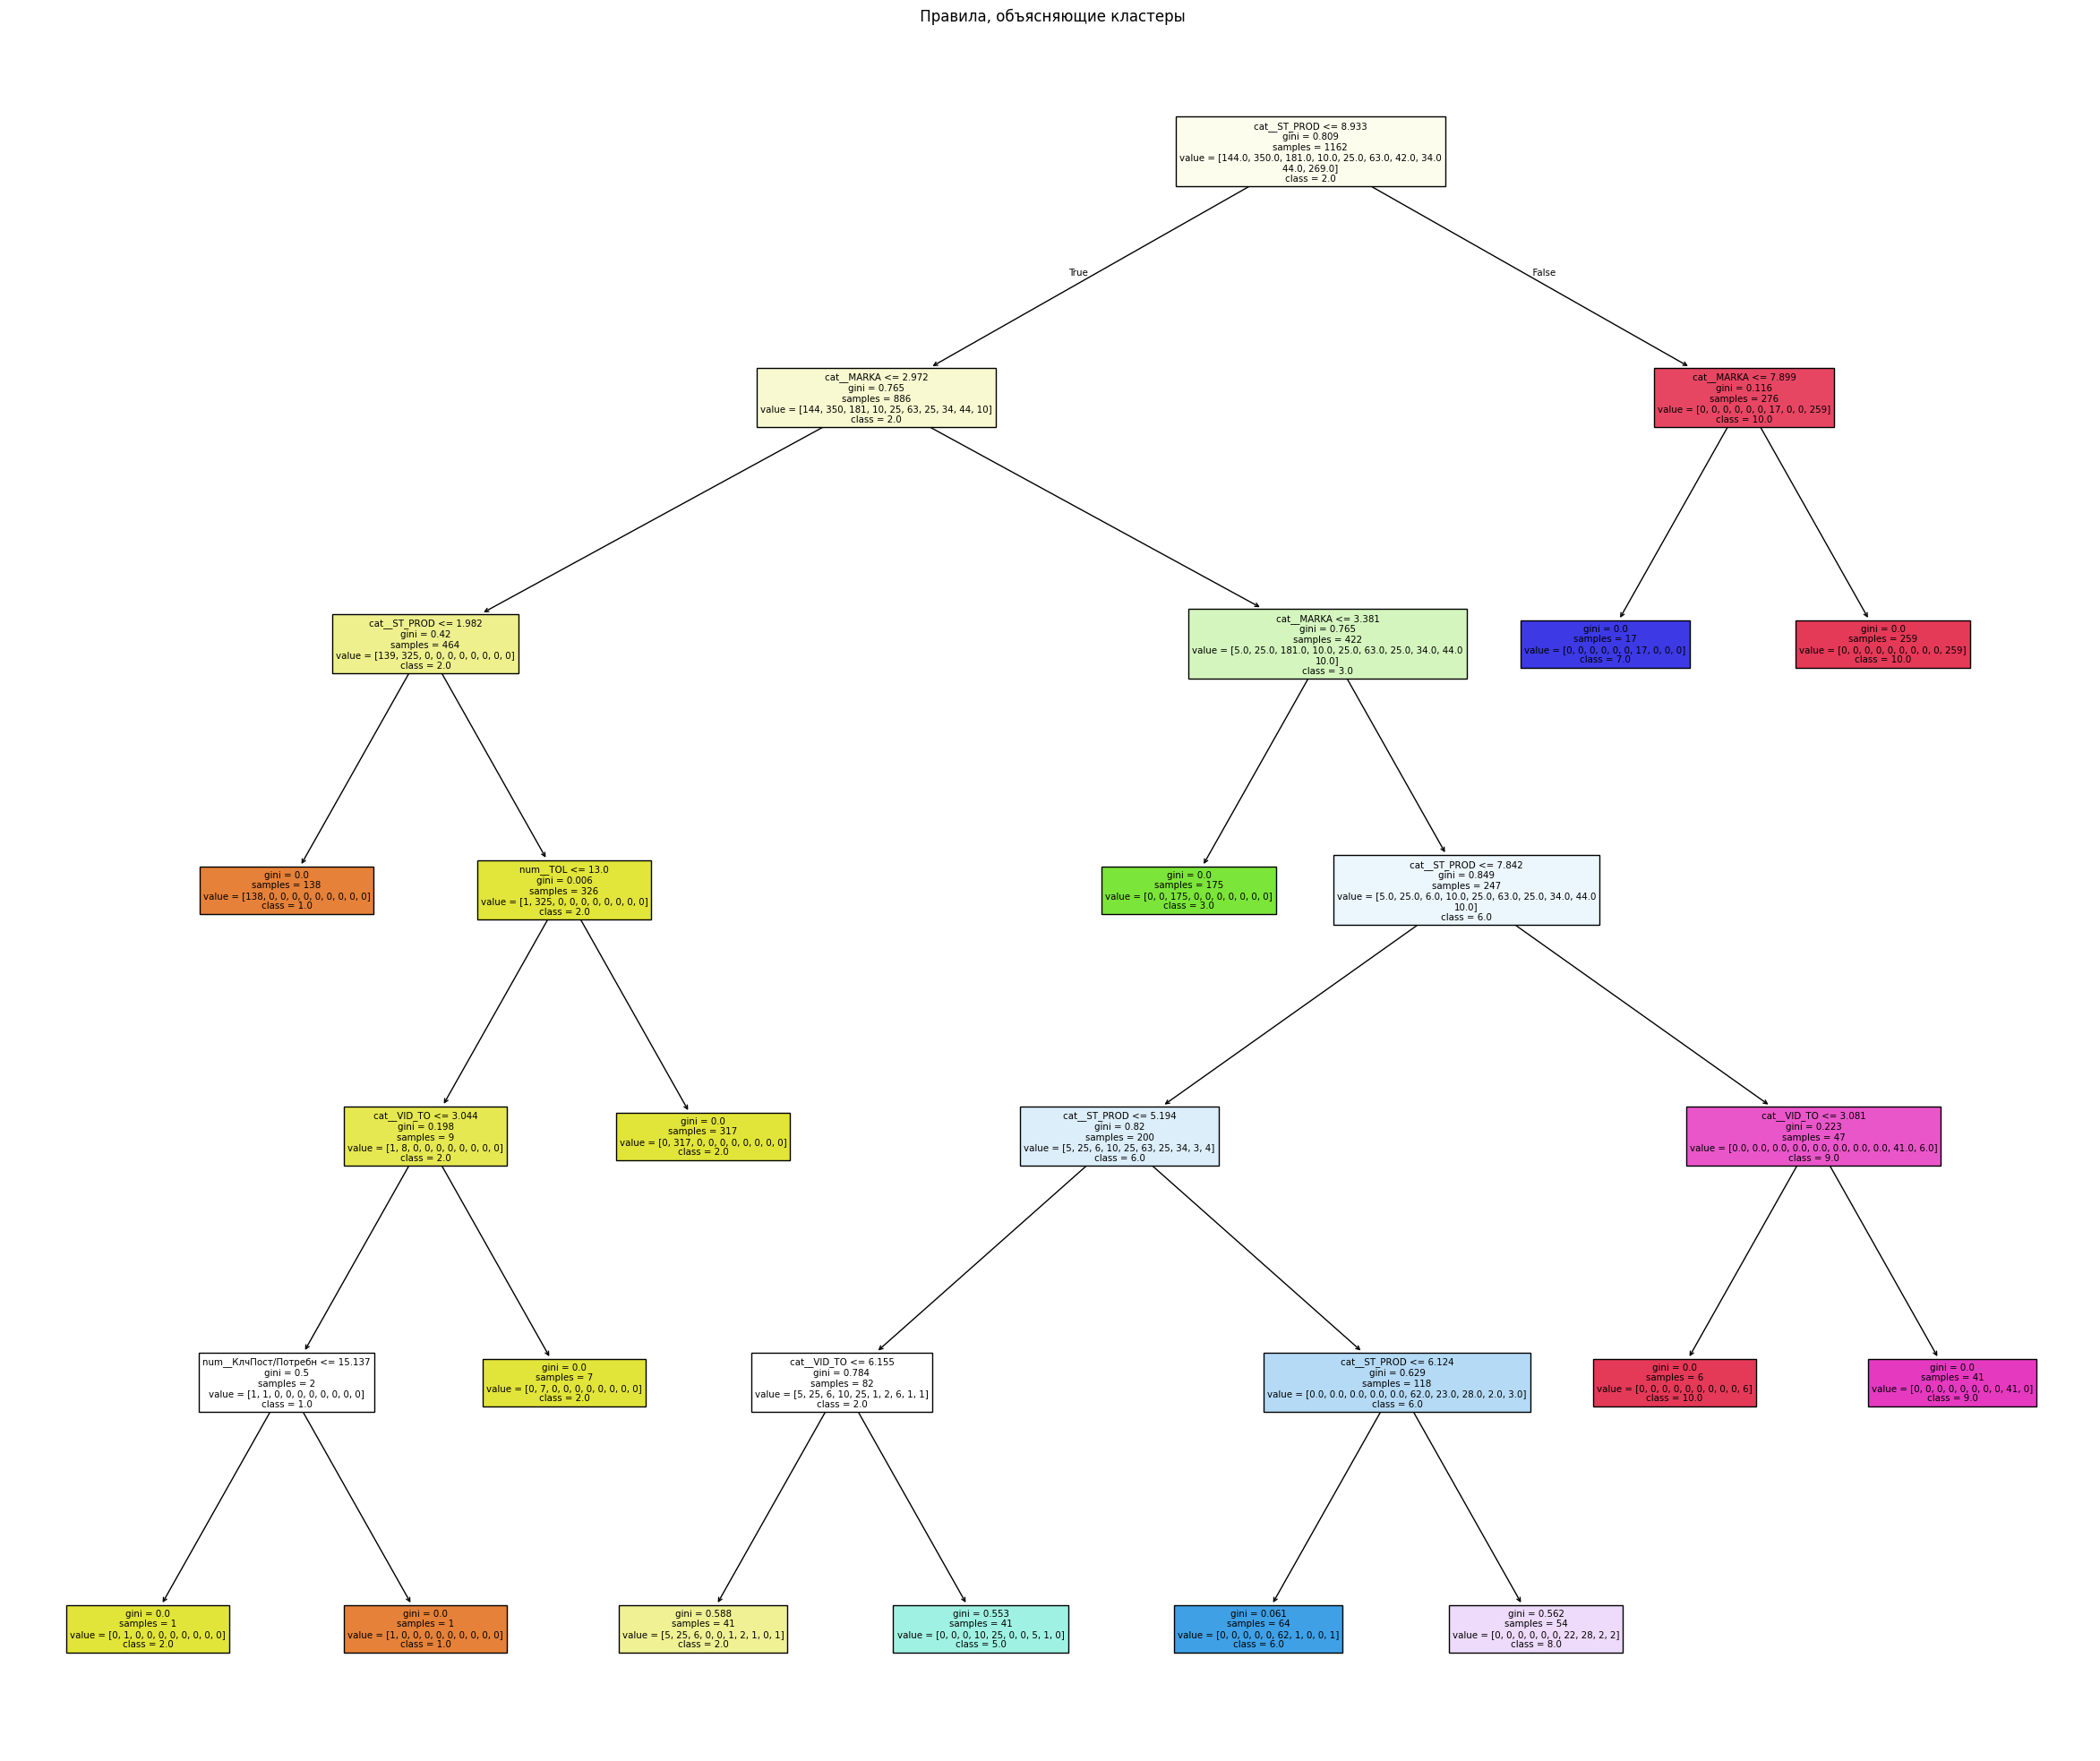


 Главные признаки, формирующие кластеры:
cat__ST_PROD            0.609865
cat__MARKA              0.355269
cat__VID_TO             0.033450
num__КлчПост/Потребн    0.001164
num__TOL                0.000252
num__SHIRINA            0.000000
num__DLINA              0.000000
dtype: float64

 Кластер 1.0: факторы, влияющие на таргет
cat__MARKA      4.583205e-01
cat__VID_TO     2.797533e-01
num__DLINA      1.321132e-01
num__TOL        1.298129e-01
cat__ST_PROD    4.742536e-14
dtype: float64


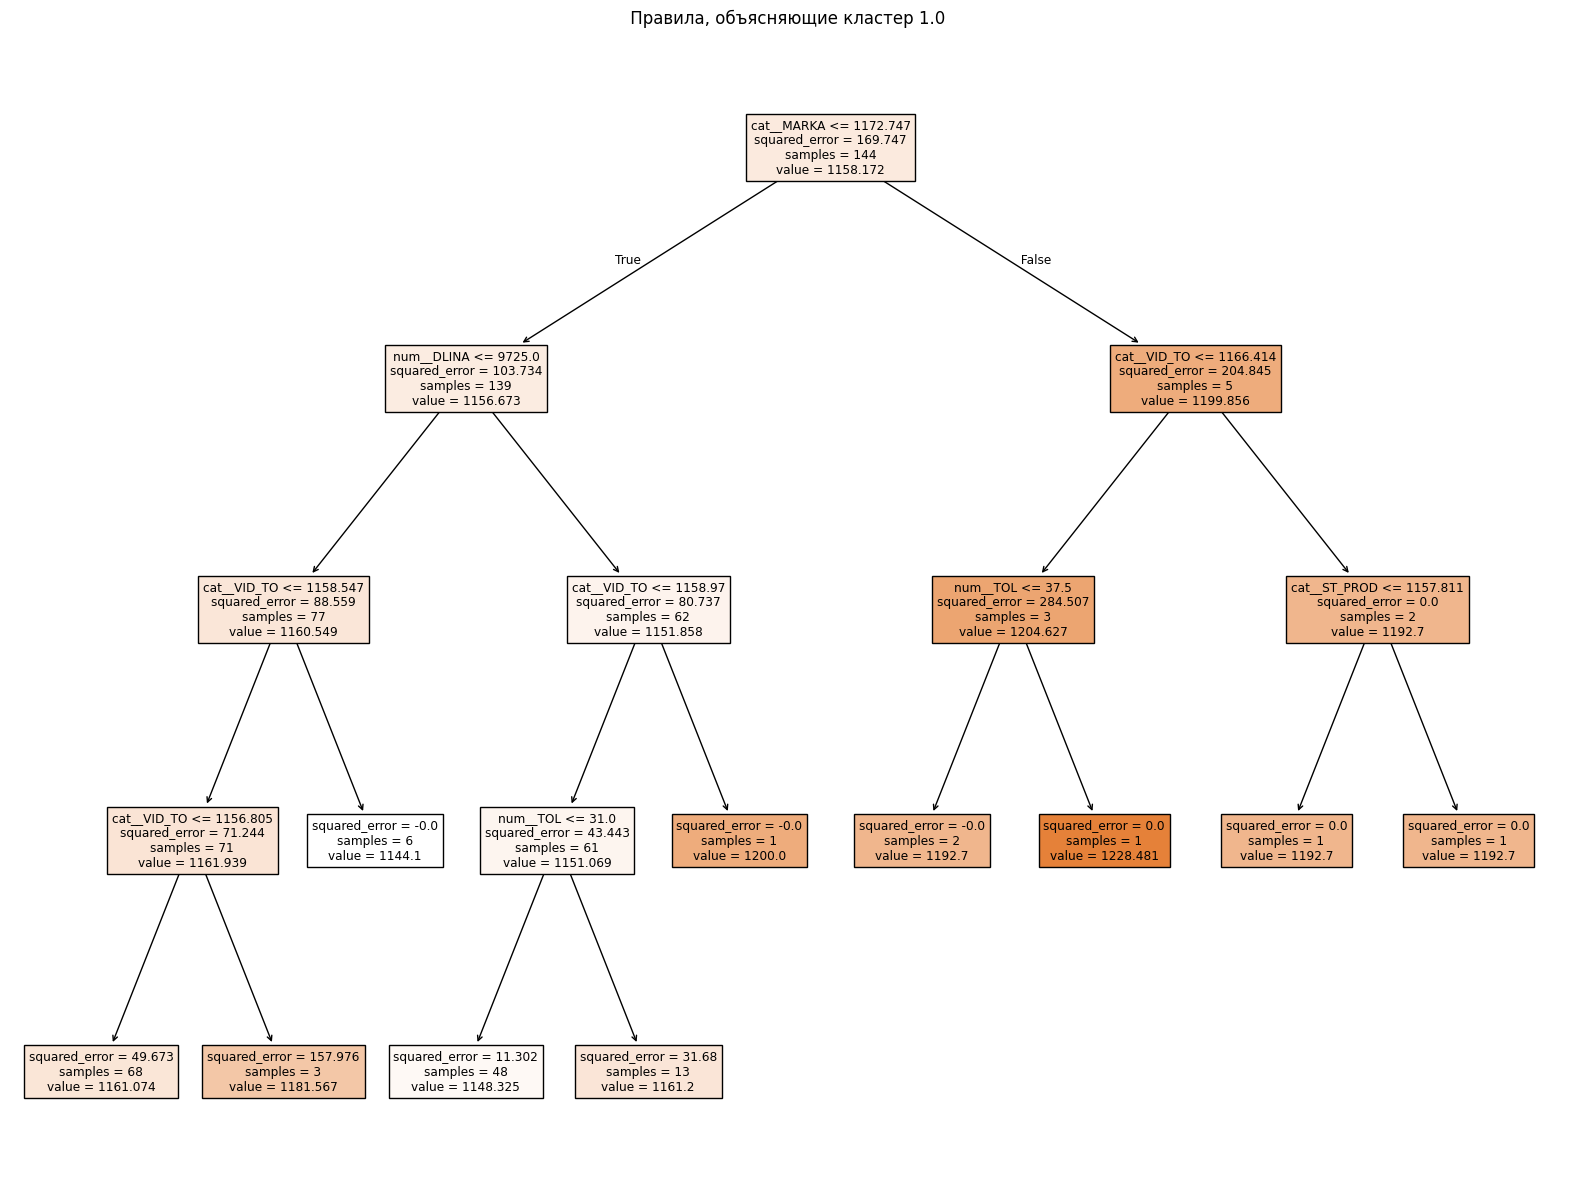


 Кластер 2.0: факторы, влияющие на таргет
num__TOL                0.669380
num__DLINA              0.195045
cat__MARKA              0.106190
cat__ST_PROD            0.023128
num__КлчПост/Потребн    0.006257
dtype: float64


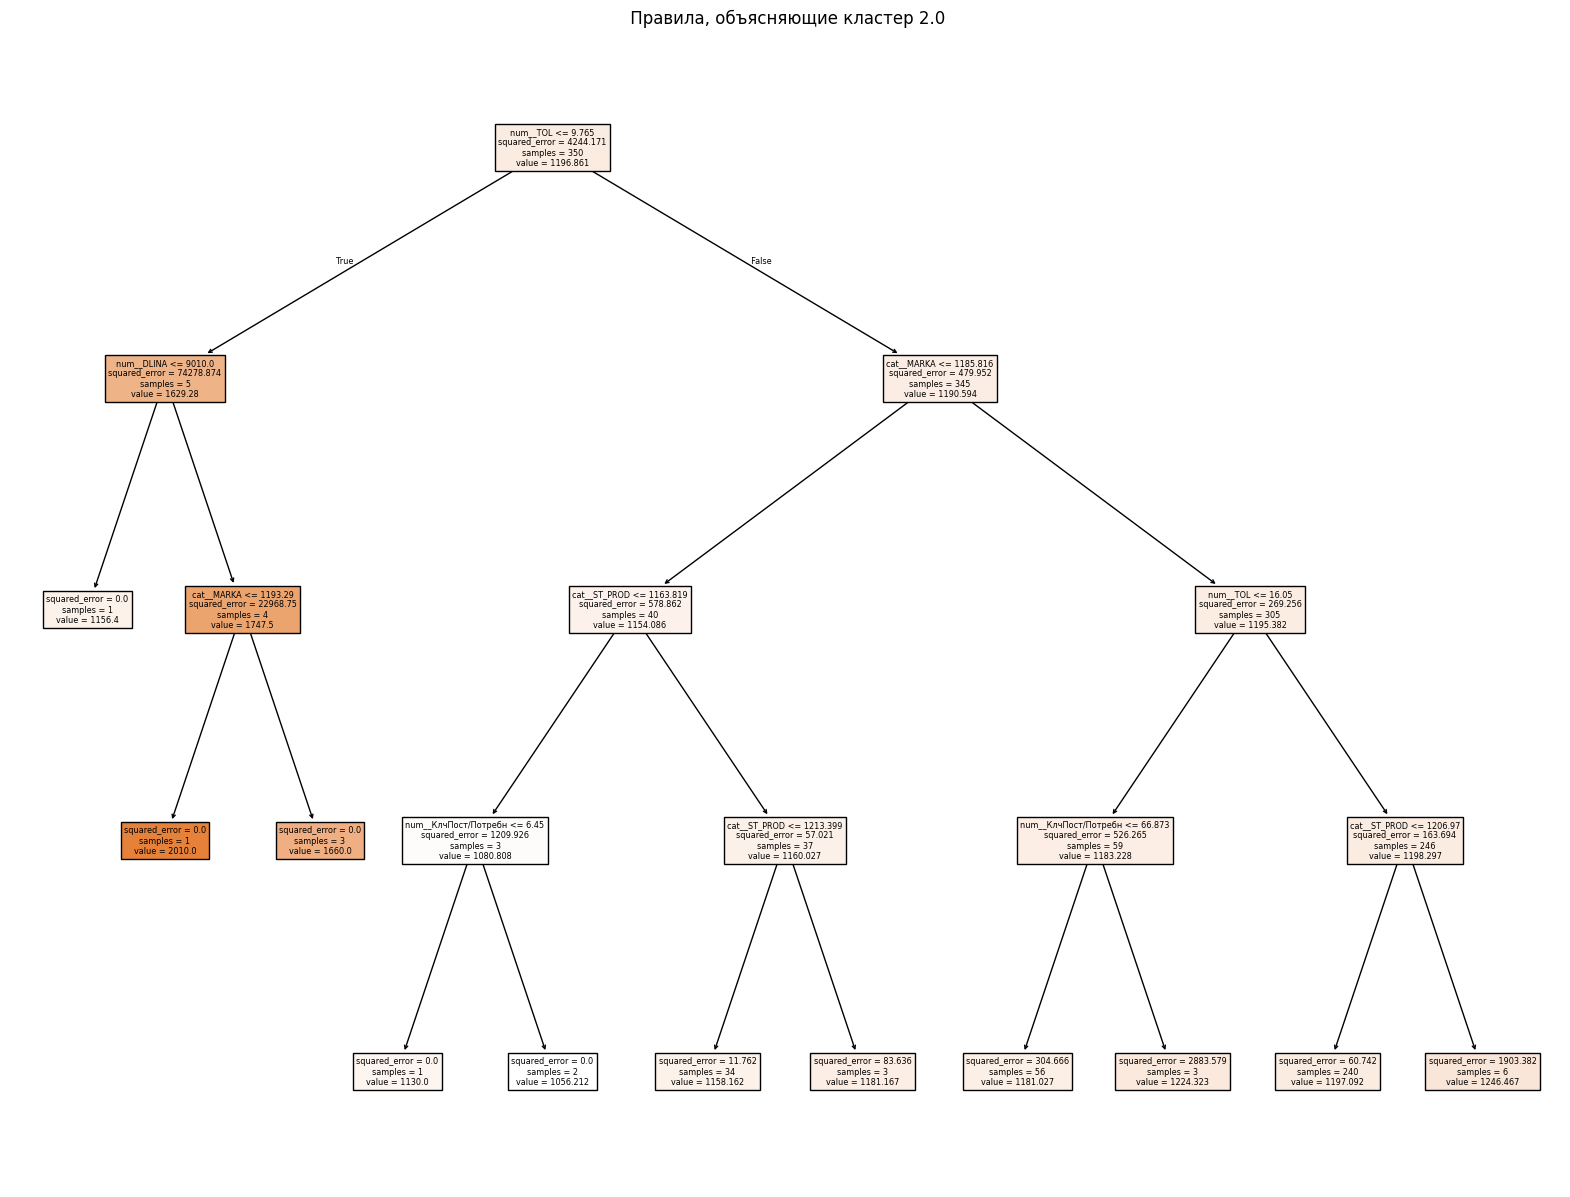


 Кластер 3.0: факторы, влияющие на таргет
num__TOL                0.409525
cat__VID_TO             0.256303
num__КлчПост/Потребн    0.151694
num__DLINA              0.079295
cat__MARKA              0.051787
dtype: float64


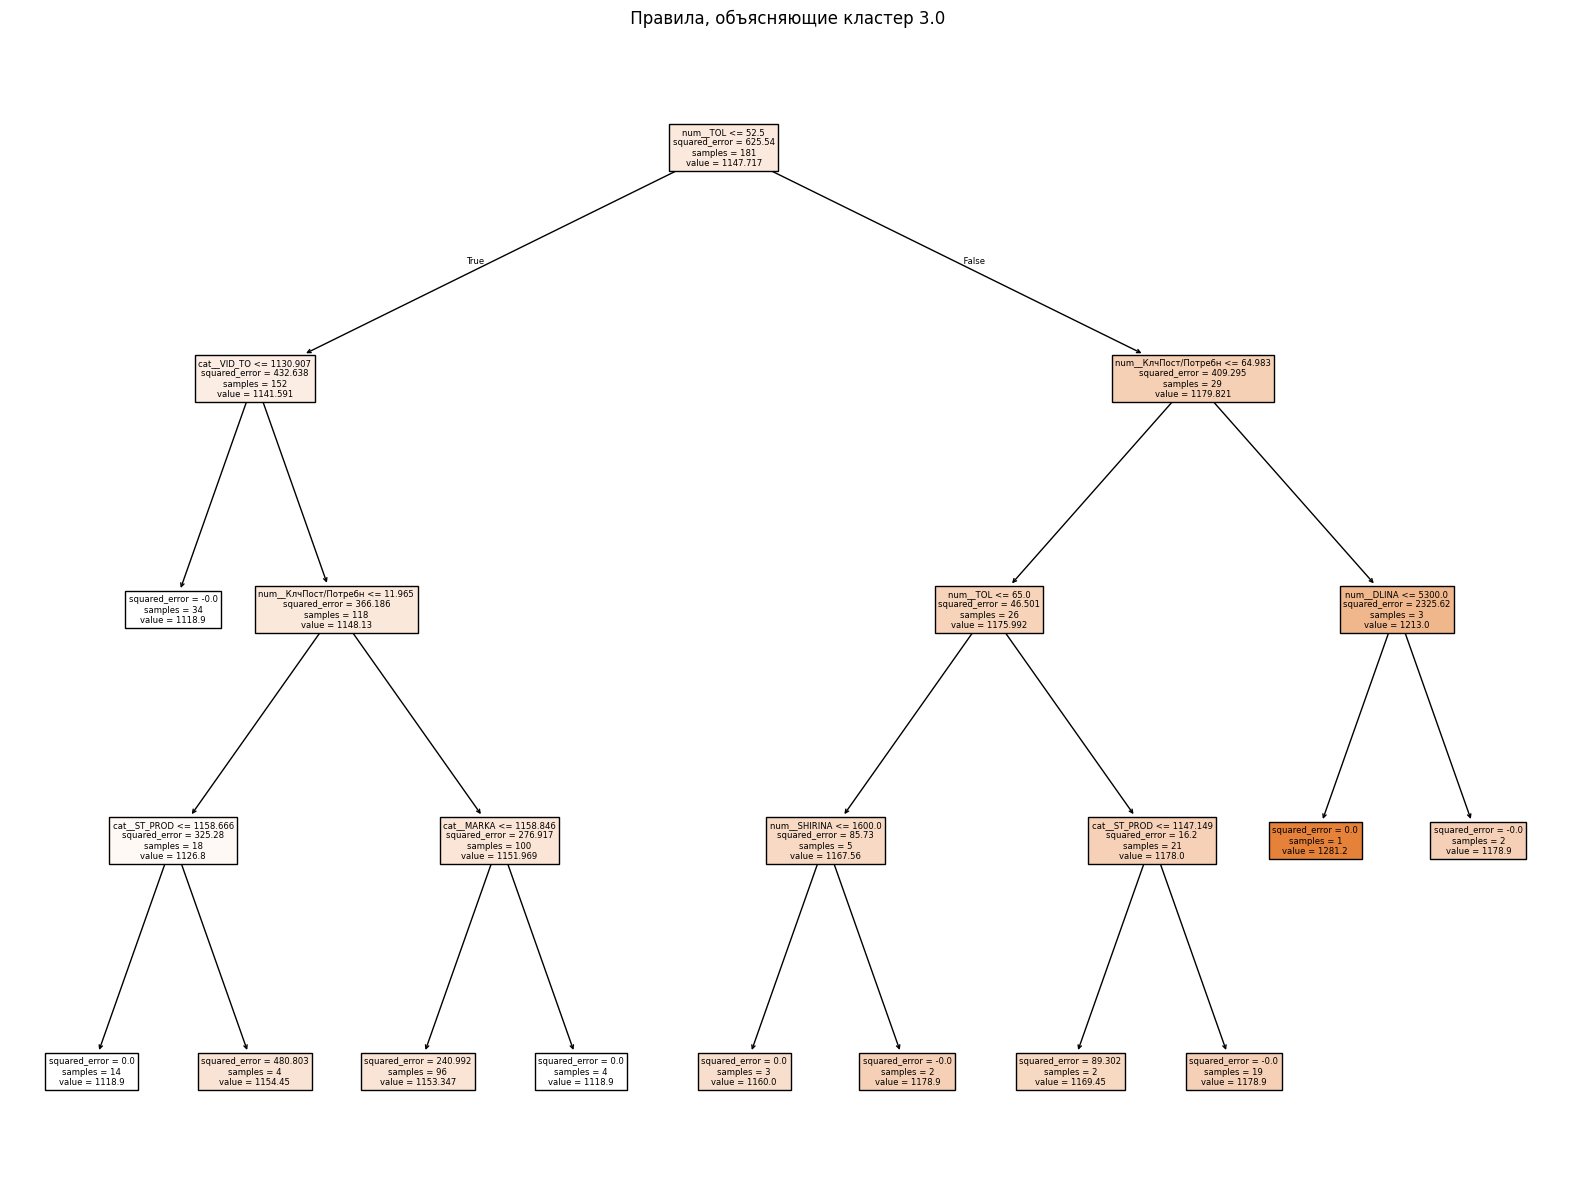


 Кластер 5.0: факторы, влияющие на таргет
num__DLINA              9.766678e-01
cat__MARKA              1.329083e-02
cat__VID_TO             7.818138e-03
num__TOL                2.223260e-03
num__КлчПост/Потребн    7.101071e-14
dtype: float64


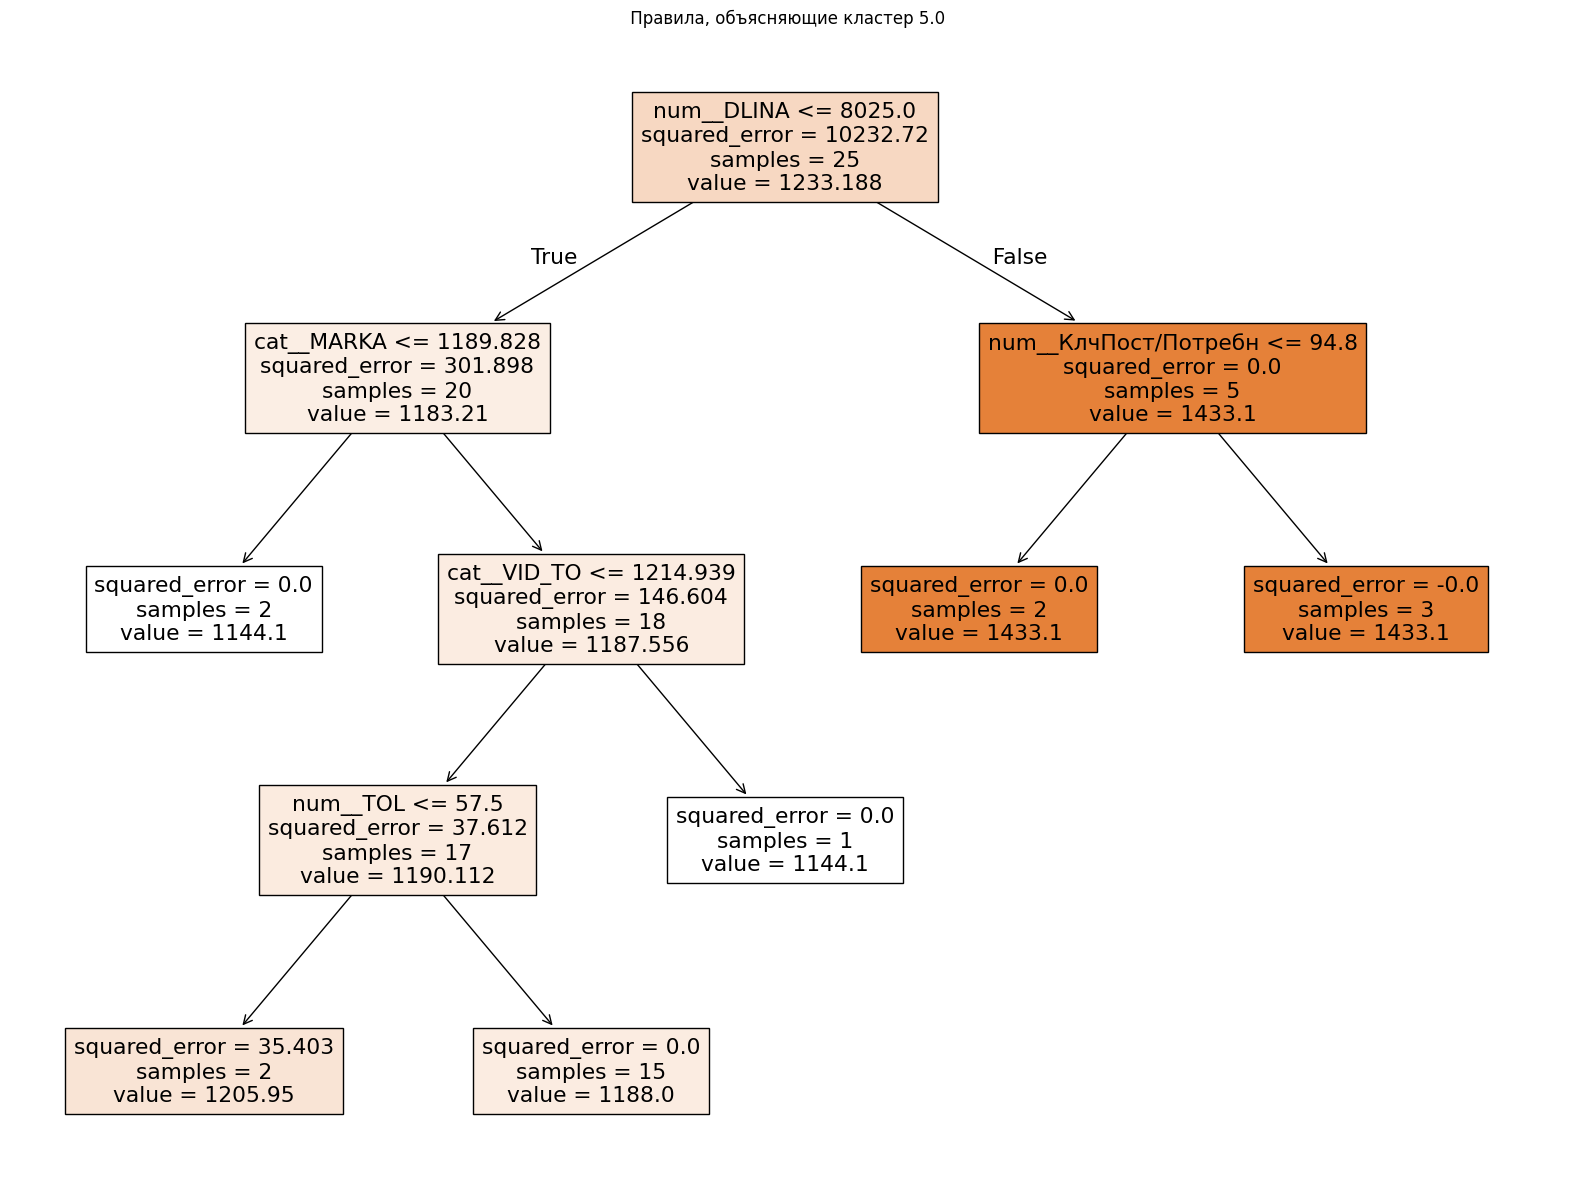


 Кластер 6.0: факторы, влияющие на таргет
num__TOL                0.759004
num__КлчПост/Потребн    0.128721
num__SHIRINA            0.093112
num__DLINA              0.019163
cat__VID_TO             0.000000
dtype: float64


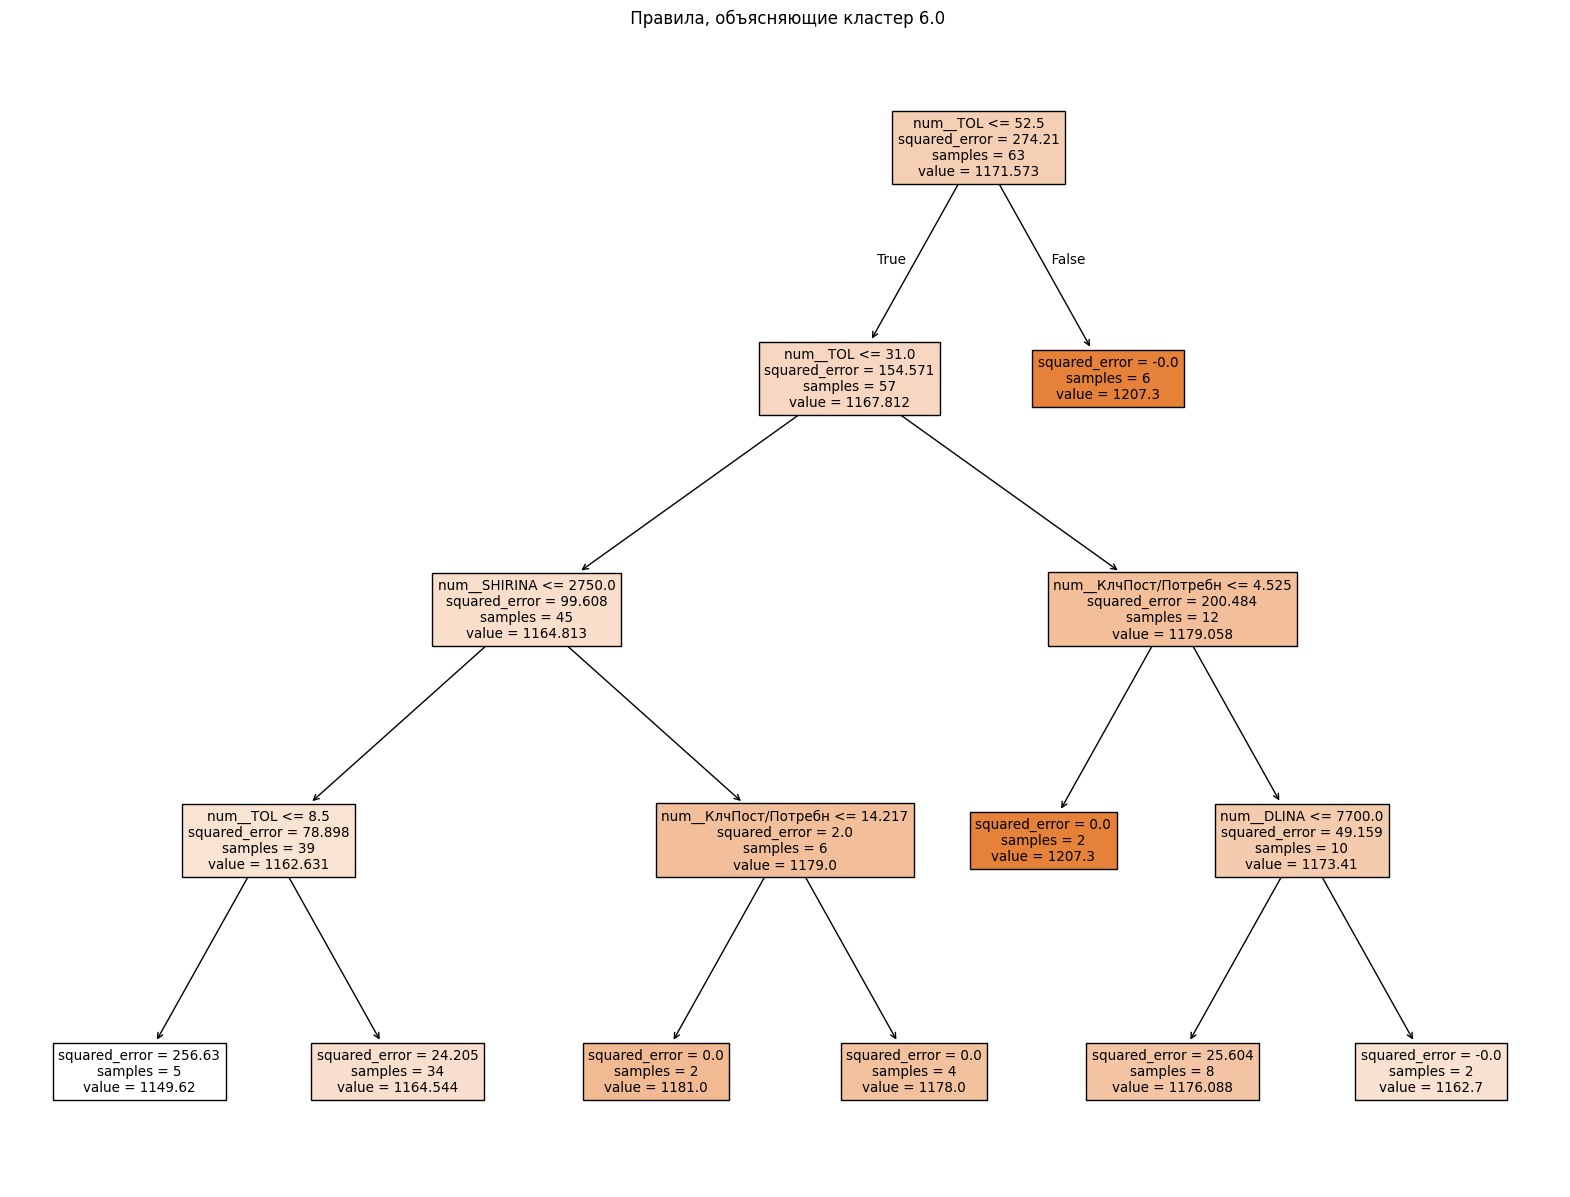


 Кластер 7.0: факторы, влияющие на таргет
cat__ST_PROD            0.780120
num__КлчПост/Потребн    0.218285
num__TOL                0.001057
num__DLINA              0.000539
num__SHIRINA            0.000000
dtype: float64


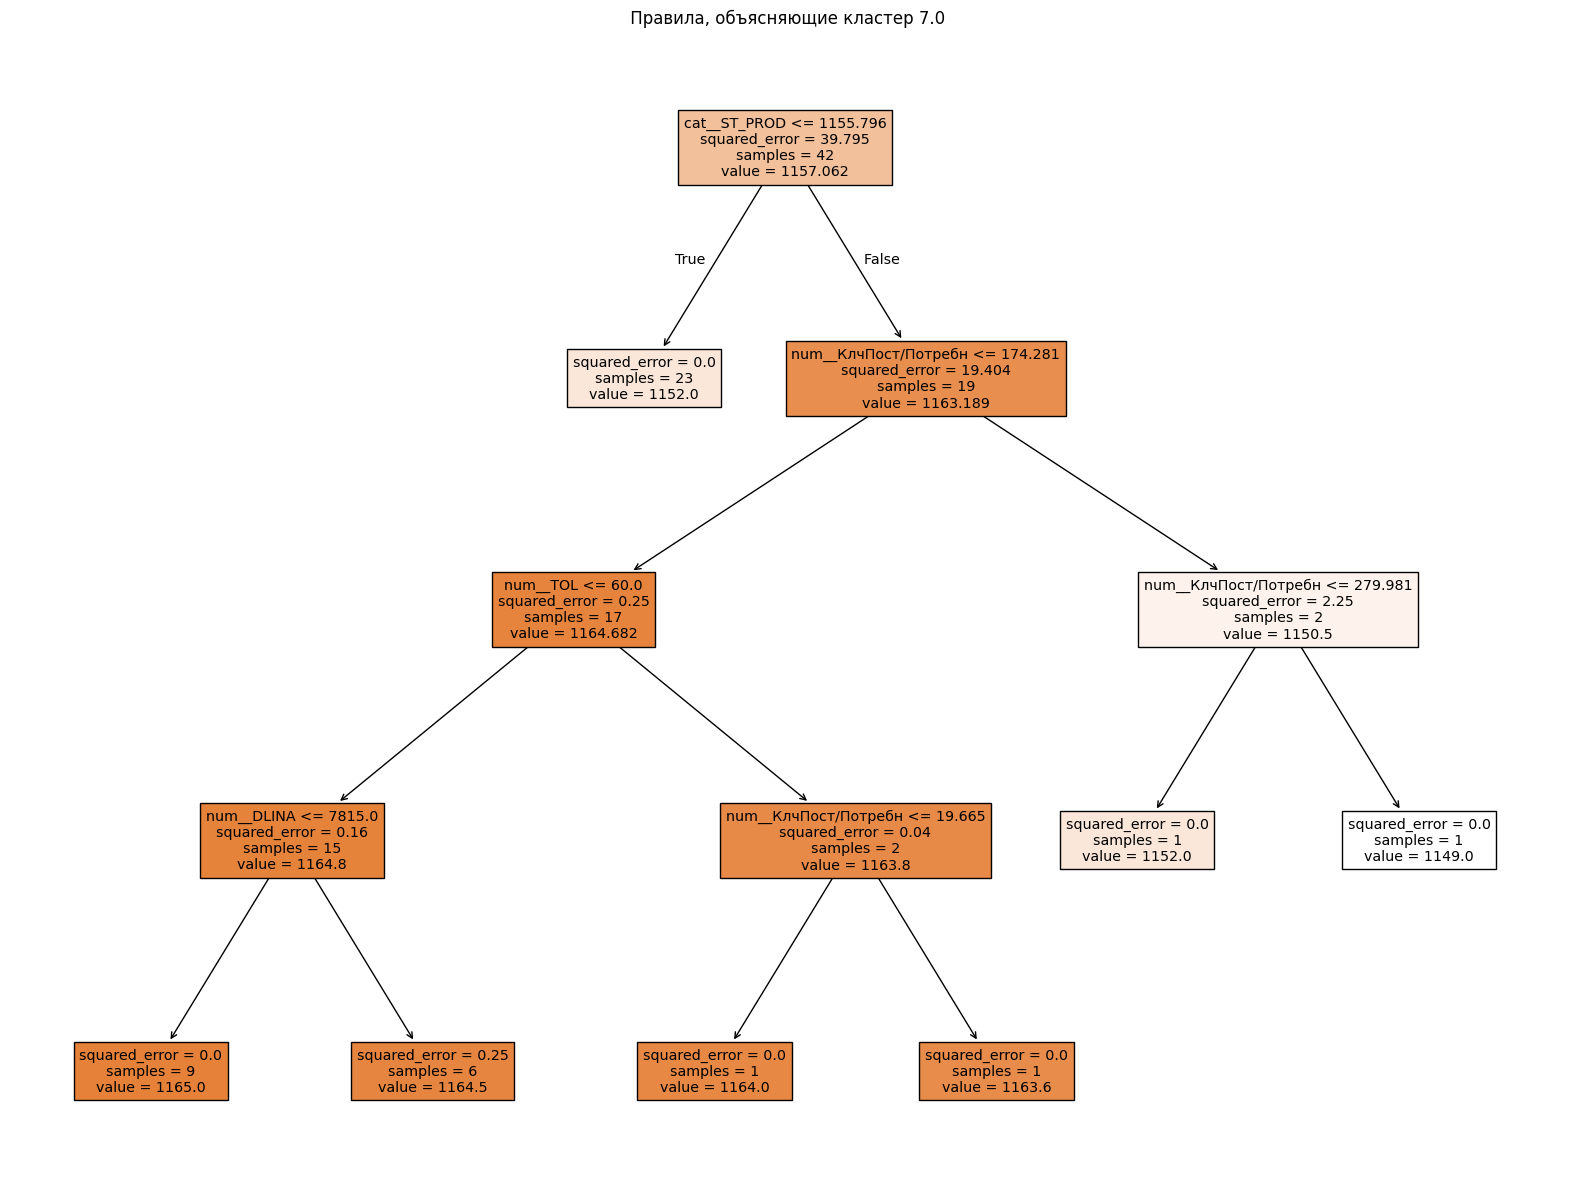


 Кластер 8.0: факторы, влияющие на таргет
num__TOL                0.484512
cat__MARKA              0.266244
cat__VID_TO             0.213926
num__КлчПост/Потребн    0.033912
num__DLINA              0.001405
dtype: float64


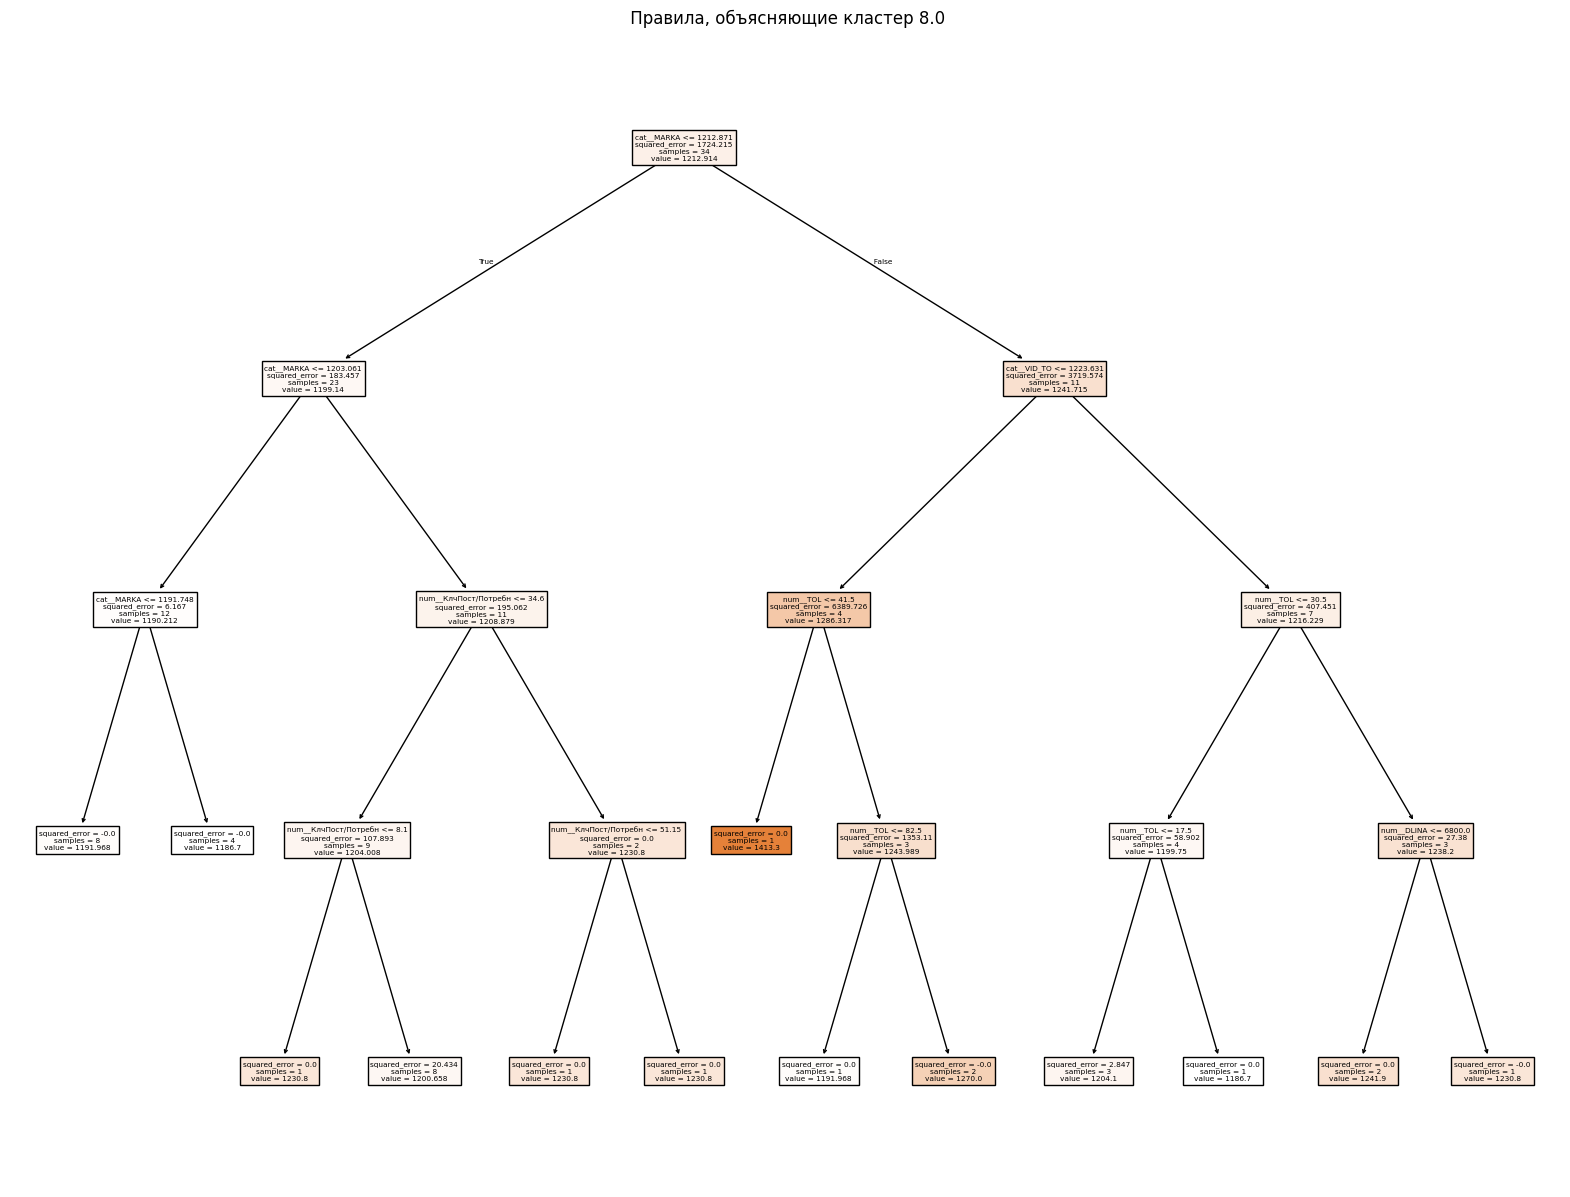


 Кластер 9.0: факторы, влияющие на таргет
num__TOL                0.854760
cat__MARKA              0.088738
cat__VID_TO             0.043641
num__SHIRINA            0.012860
num__КлчПост/Потребн    0.000000
dtype: float64


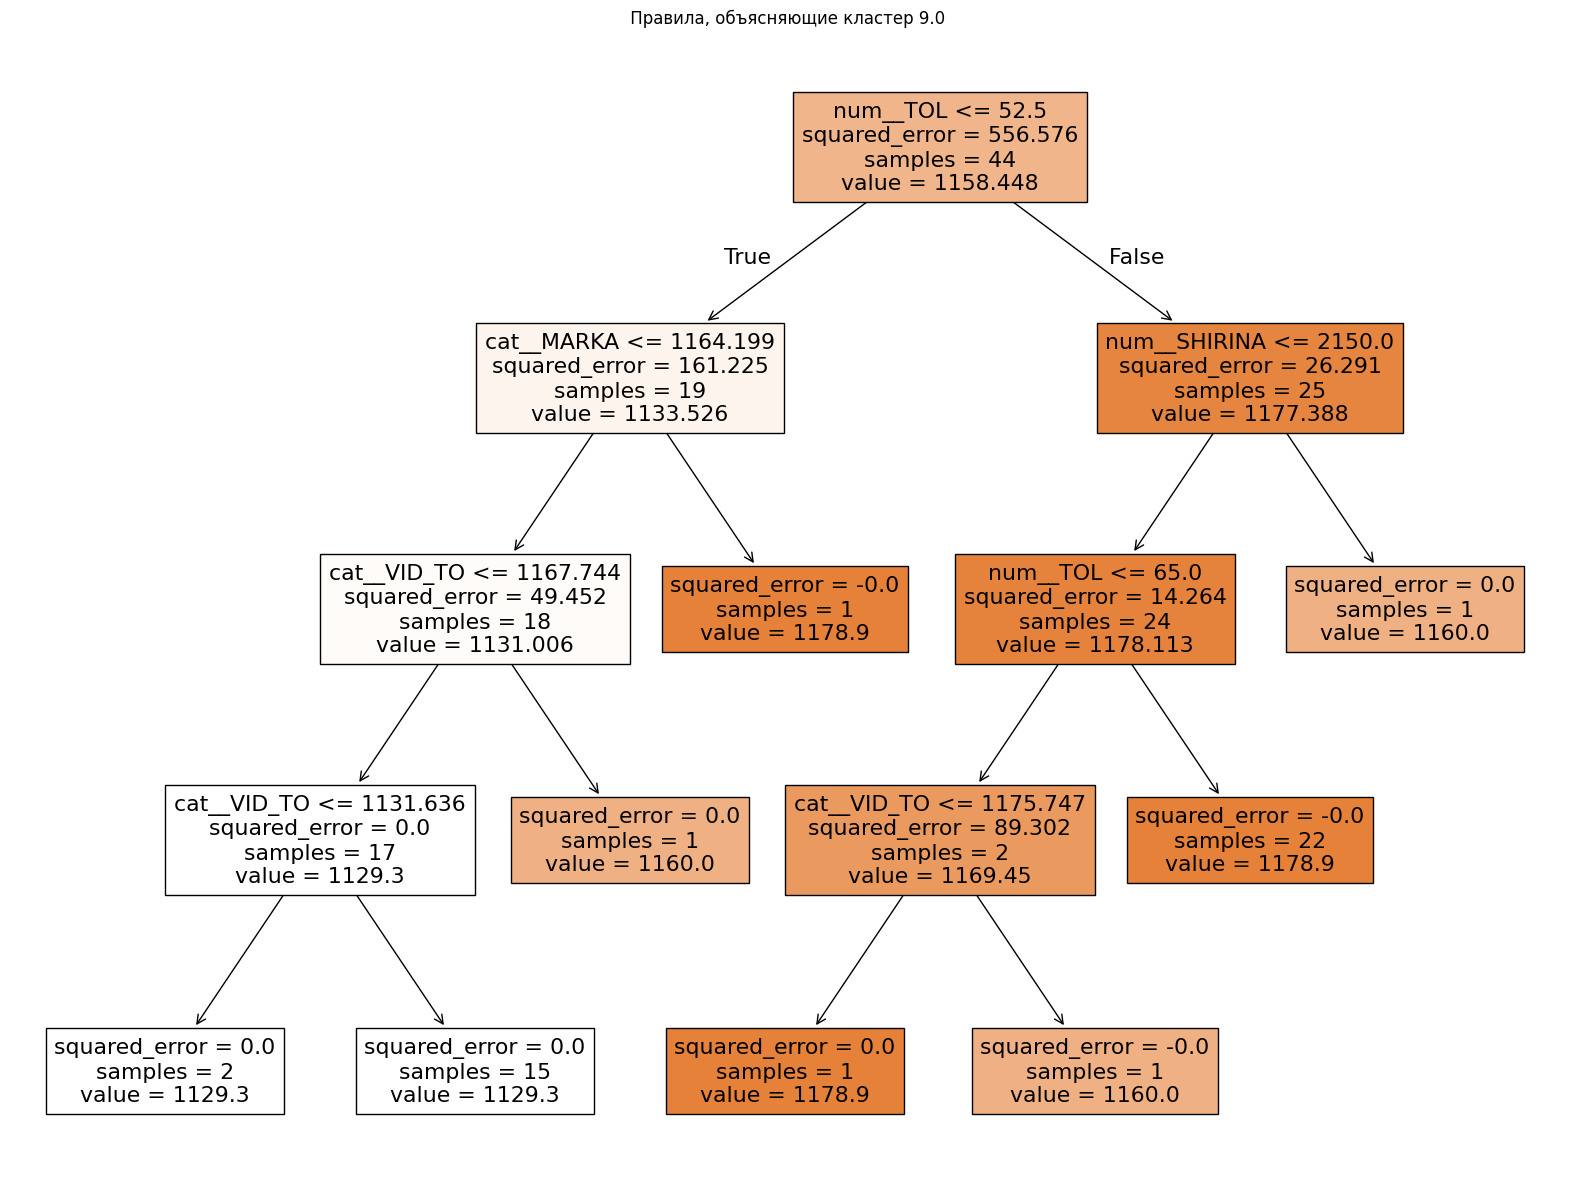


 Кластер 10.0: факторы, влияющие на таргет
cat__ST_PROD    0.462003
cat__VID_TO     0.257198
num__TOL        0.158156
num__SHIRINA    0.106935
num__DLINA      0.015708
dtype: float64


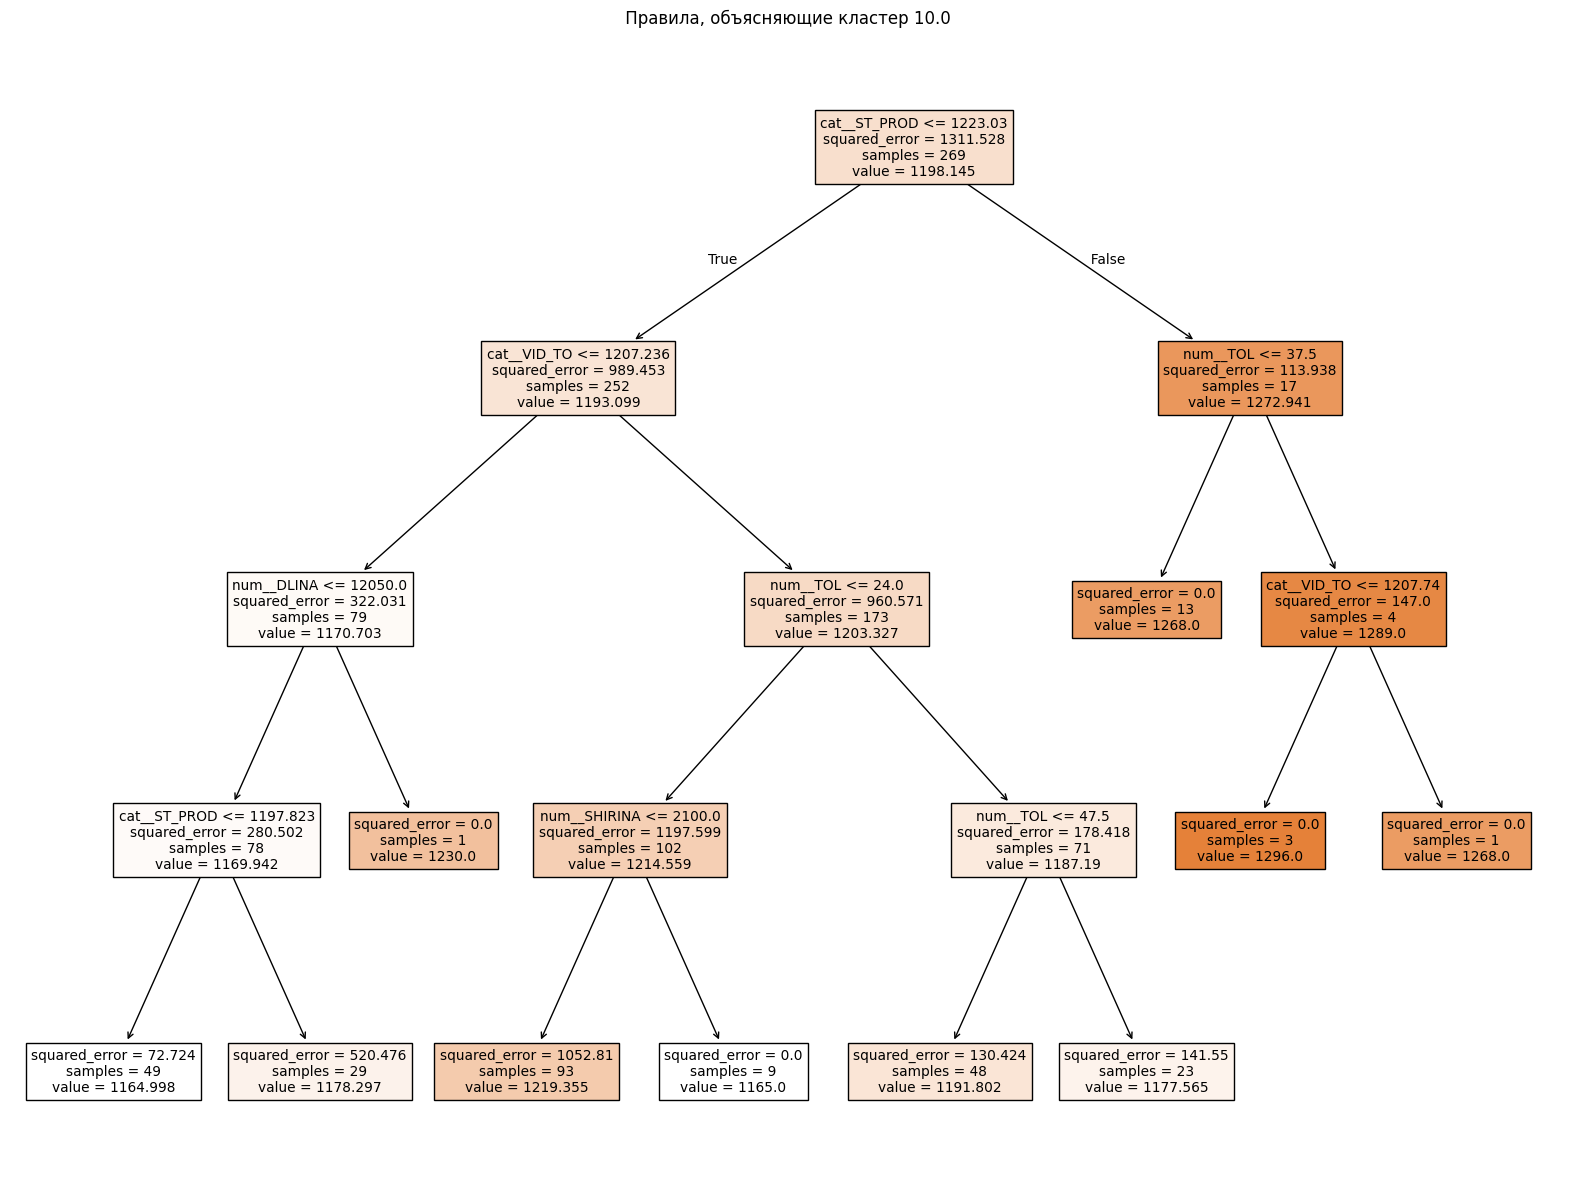

In [ ]:
analyze_clusters(df.drop(['Номер Z-конфигурации'], axis=1));